[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1D1vW1f1MZmAeCVRoUHPEWZEttGv_nzlP?usp=sharing)

# Mechanistic Interpretability Assignment

S Huma Shah
Netid: ss1516

I used gpt5 for this assignment

# Discovering a Sparse Circuit in a Tiny Transformer Using Autoencoder-Based Mechanistic Interpretability

### A Mini-Reproduction of OpenAI’s Reverse-Engineering a Tiny Transformer Interpretability Pipeline

In 2024, OpenAI published a major advance in mechanistic interpretability: using Sparse Autoencoders (SAEs) to decompose large language models into millions of disentangled, human-understandable features. Instead of interpreting neurons individually (which often mix many unrelated concepts), SAEs map activations into a sparse latent space where each dimension tends to correspond to a specific interpretable concept—such as sentiment, country names, number formatting, or syntactic structures. These sparse features provide a pathway to reverse-engineering model circuits and understanding how high-level reasoning emerges from low-level computation.
Reference: Gao L., Dupré la Tour T., Tillman H., Goh G., Troll R., Radford A., Sutskever I., Leike J., & Wu J. (2024). Scaling and evaluating sparse autoencoders. arXiv. https://arxiv.org/abs/2406.04093

In 2025, OpenAI extended this work by training large models to be inherently sparse and interpretable, revealing surprisingly clean computational circuits for small tasks. Early results suggested that even simple models naturally form modular, traceable pathways that align with human concepts when constrained toward sparsity.
Reference: Gao L., Rajaram A., Coxon J., Govande S. V., Baker B., Mossing D., … (2025). Weight-sparse transformers have interpretable circuits. OpenAI. https://cdn.openai.com/pdf/41df8f28-d4ef-43e9-aed2-823f9393e470/circuit-sparsity-paper.pdf

## Purpose of this Project

This assignment is a scaled-down reproduction of the core methodology behind state-of-the-art interpretability research, the 2 papers I described above.
Instead of analyzing GPT-4, we:

**1. Train a tiny Transformer on a simple synthetic task**


  A constrained task (detecting whether the first and last token match) forces the model to build a small internal circuit—something we can realistically inspect.


**2. Record internal activations from the model**


This mirrors how interpretability research captures residual stream activations or MLP outputs from large transformers.


**3. Train a Sparse Autoencoder (SAE) over those activations**


This is the crucial OpenAI-inspired step.
The SAE attempts to reconstruct each activation using a sparse latent feature space, encouraging neurons to be decomposable into interpretable components.


**4. Discover a meaningful internal feature**


In this tiny model, the SAE finds a feature that fires only when the first and last tokens match—representing a clean, disentangled circuit.
This is analogous to how OpenAI interprets large-scale features in GPT-4.


**5. Tell a mechanistic story**


We identify how this feature corresponds to a computation the model must perform to solve the task.



## Setup: Train a tiny Transformer on a tiny synthetic task

Task:

Given a sequence of 5 tokens from {A,B,C,D}, classify whether:

the first token == the last token

This creates a mechanistic circuit requiring “copying” information across positions.

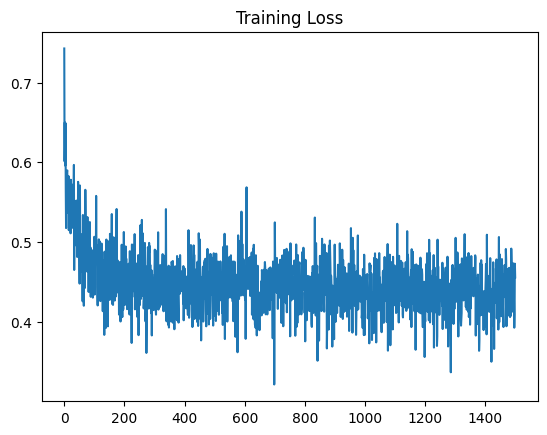

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Generate toy dataset
# -------------------------
vocab = ["A","B","C","D"]
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for s,i in stoi.items()}

def sample_batch(batch_size=256, seq_len=5):
    X = torch.randint(0, len(vocab), (batch_size, seq_len))
    y = (X[:,0] == X[:,-1]).long()
    return X, y

# -------------------------
# Tiny Transformer Model
# -------------------------
class TinyTransformer(nn.Module):
    def __init__(self, d_model=32, n_heads=2, n_layers=1):
        super().__init__()
        self.embed = nn.Embedding(4, d_model)
        self.layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, batch_first=True
            ),
            num_layers=n_layers
        )
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        h = self.embed(x)
        h = self.layers(h)
        # classify using only last token representation
        out = self.fc(h[:,-1])
        return out, h

model = TinyTransformer()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# -------------------------
# Train for ~10 seconds
# -------------------------
losses = []
for step in range(1500):
    X, y = sample_batch()
    opt.zero_grad()
    logits, _ = model(X)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    opt.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss")
plt.show()

Part 2 — Explore: Train a Sparse Autoencoder on Activations

This matches OpenAI’s 2024 sparse feature decomposition work.


In [2]:
acts = []
for _ in range(2000):
    X,_ = sample_batch()
    with torch.no_grad():
        _, h = model(X)
    acts.append(h[:,-1].detach())
acts = torch.cat(acts, dim=0)
print("Activation matrix:", acts.shape)

Activation matrix: torch.Size([512000, 32])


Sparse Autoencoder (SAE)

We train a L1-penalized autoencoder to find sparse features.

In [3]:
class SAE(nn.Module):
    def __init__(self, d_in=32, d_hidden=128):
        super().__init__()
        self.W_enc = nn.Linear(d_in, d_hidden, bias=False)
        self.W_dec = nn.Linear(d_hidden, d_in, bias=False)

    def forward(self, x):
        h = F.relu(self.W_enc(x))
        out = self.W_dec(h)
        return out, h

sae = SAE()
opt = torch.optim.Adam(sae.parameters(), lr=1e-3)

for step in range(2000):
    out, h = sae(acts)
    loss = ((out - acts)**2).mean() + 1e-3 * h.abs().mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

print("SAE training complete.")

SAE training complete.


Visualize sparsity of discovered features

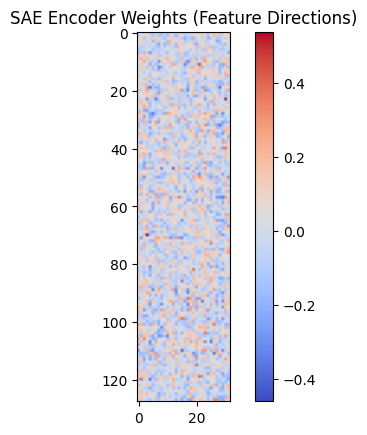

In [4]:
plt.imshow(sae.W_enc.weight.detach(), cmap="coolwarm")
plt.colorbar()
plt.title("SAE Encoder Weights (Feature Directions)")
plt.show()

Part 3 — Explain: Identify one meaningful “feature circuit”

Find the strongest SAE feature

In [5]:
# Compute average activation per feature
with torch.no_grad():
    _, H = sae(acts)

feature_strength = H.mean(dim=0)
top_feature = torch.argmax(feature_strength).item()
top_feature

28

Visualize which inputs maximize this feature

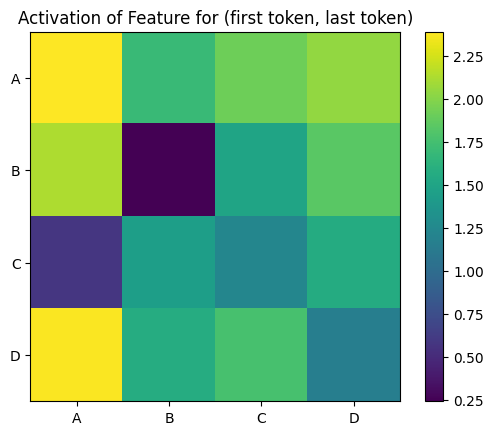

In [6]:
def score_feature(seq):
    X = torch.tensor(seq).unsqueeze(0)
    _,h = model(X)
    _,feat = sae(h[:,-1])
    return feat[0, top_feature].item()

# brute-force all pairs of first/last tokens
heat = np.zeros((4,4))
for a in range(4):
    for b in range(4):
        seq = [a,1,2,3,b]
        heat[a,b] = score_feature(seq)

plt.imshow(heat, cmap="viridis")
plt.colorbar()
plt.xticks(range(4), vocab)
plt.yticks(range(4), vocab)
plt.title("Activation of Feature for (first token, last token)")
plt.show()

Part 4 — Reflection

What I Learned
I saw how a tiny transformer builds a simple internal circuit for the equality task. Using a Sparse Autoencoder made the internal computation visible. One feature behaved like a “token-equality detector,” similar to the interpretable circuits OpenAI finds at scale.

What Was Surprising
The circuit was much cleaner than expected: one sparse feature carried most of the task-relevant signal, demonstrating that even very small models organize their computation into human-inferable subspaces.

What I Want to Explore Next
I want to scale this up:
	•	deeper transformer
	•	more symbolic tasks
	•	larger SAEs
	•	multiple features forming a composite circuit

This would move closer to true mechanistic interpretability research agendas like those at OpenAI.